In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import BaggingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.utils.validation import has_fit_parameter


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [17]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 讀取 CSV 檔案
df = pd.read_csv(r'北北桃5_filter_outlier.csv')
df = df[df['縣市'] == '台北市']  

# Function to preprocess and split data by district
def get_country(df, district):
    df_district = df[df['鄉鎮市區'] == district].copy()
    df_district['交易年月日'] = pd.to_datetime(df_district['交易年月日'])
    df_district.set_index('交易年月日', inplace=True)

    # Split data into training and test sets
    train_df = df_district[df_district.index <= '2023-12-31']
    test_df = df_district[(df_district.index > '2023-12-31') & (df_district.index < '2024-08-31')]
    train_df = train_df[~((train_df['年_民國'] == 113) & (train_df['月'] == 9))]

    # Define features and target
    features_to_drop = ['編號', '總價元', '單價元平方公尺', '建築完成年月', '土地位置建物門牌', '建物移轉總面積平方公尺', '交易標的',
                        '都市土地使用分區', '備註', '移轉層次', '總樓層數', '單價元/坪', 
                        '車位總價元', '附屬建物面積', '陽台面積', 
                        '嫌惡設施_500內', '嫌惡設施_500到1000', '學校_500內', '學校_500到1000', '公園_500內', 
                        '公園_500到1000', '公車站_500內', '公車站_500到1000', '捷運站_500內', '捷運站_500到1000',
                        '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']

    X_train = train_df.drop(features_to_drop, axis=1)
    y_train = train_df['單價元/坪']
    X_test = test_df.drop(features_to_drop, axis=1)
    y_test = test_df['單價元/坪']

    # Preprocess categorical and continuous features
    one_hot_cols = ['鄉鎮市區', '主要用途', '主要建材', '車位類別', '建物型態', '縣市']
    X_train_one_hot = pd.get_dummies(X_train[one_hot_cols], drop_first=True)
    X_test_one_hot = pd.get_dummies(X_test[one_hot_cols], drop_first=True)
    X_train_one_hot, X_test_one_hot = X_train_one_hot.align(X_test_one_hot, join='outer', axis=1, fill_value=0)

    # Standardize continuous features
    continuos_col_name = X_train.drop(columns=one_hot_cols).select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_train_continuos_scaled = pd.DataFrame(scaler.fit_transform(X_train[continuos_col_name]), index=X_train.index, columns=continuos_col_name)
    X_test_continuos_scaled = pd.DataFrame(scaler.transform(X_test[continuos_col_name]), index=X_test.index, columns=continuos_col_name)

    # Concatenate processed features
    X_train_final = pd.concat([X_train_continuos_scaled, X_train_one_hot], axis=1)
    X_test_final = pd.concat([X_test_continuos_scaled, X_test_one_hot], axis=1)
    
    return X_train_final, X_test_final, y_train, y_test, train_df, test_df 

# Function to get feature importance using RandomForest
def get_feature_importance(X_train_final, X_test_final, y_train, y_test):
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_final, y_train)

    feature_importances = rf_model.feature_importances_
    feature_names = X_train_final.columns

    # Sort and select top features
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
    top_feature_names = top_features['Feature'].tolist()
    
    return X_train_final[top_feature_names], X_test_final[top_feature_names], top_features


    



In [18]:


def evaluate_model(models, X_train_top, y_train, X_test_top, y_test, train_df, test_df, country_name):
    for name, model in models.items():
        print(f"Evaluating {name}")
        print("-" * 50)

        # Train the model
        model.fit(X_train_top, y_train)

        # Predict on training and test sets
        y_pred_train = model.predict(X_train_top)
        y_pred_test = model.predict(X_test_top)

        # Calculate mean squared error
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)

        # Calculate mean absolute error
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # Calculate R²
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        # Calculate RMSE
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        # Prepare the results for train and test
        test_results = pd.DataFrame({
            '交易年月日': X_test_top.index.ravel(),
            '單價元/坪預測值': y_pred_test.ravel()
        })
        train_results = pd.DataFrame({
            '交易年月日': X_train_top.index.ravel(),
            '單價元/坪預測值': y_pred_train.ravel()
        })

        # Merge train and test results
        combined_results = pd.concat([train_results, test_results])

        # Convert the date column to datetime
        combined_results['交易年月日'] = pd.to_datetime(combined_results['交易年月日'])
        combined_results.set_index('交易年月日', inplace=True)

        # Group by month and calculate average predicted prices
        monthly_avg_predicted_prices = combined_results.resample('M').mean()

        # Plot the predicted house prices each month
        plt.figure(figsize=(10, 6))
        plt.plot(monthly_avg_predicted_prices.index, monthly_avg_predicted_prices['單價元/坪預測值'], marker='o', label='Predicted')

        # Prepare the actual values for train and test
        train_df['交易年月日'] = pd.to_datetime(train_df.index)
        test_df['交易年月日'] = pd.to_datetime(test_df.index)

        combined_actual = pd.concat([train_df[['交易年月日', '單價元/坪']], test_df[['交易年月日', '單價元/坪']]])
        combined_actual.set_index('交易年月日', inplace=True)
        monthly_avg_actual_prices = combined_actual.resample('M').mean()

        # Plot actual values
        plt.plot(monthly_avg_actual_prices.index, monthly_avg_actual_prices['單價元/坪'], marker='o', label='Actual')

        # Add labels and title
        plt.xlabel('年')
        plt.ylabel('單價元/坪')
        plt.title(f'{country_name} 平均單價元/坪 ({name})')
        plt.legend()
        plt.grid(True)

        # Metrics text for train and test
        metrics_text_train = (f"MSE (Train): {mse_train:.2f}\n"
                              f"MAE (Train): {mae_train:.2f}\n"
                              f"RMSE (Train): {rmse_train:.2f}\n"
                              f"R² (Train): {r2_train:.2f}")

        metrics_text_test = (f"MSE (Test): {mse_test:.2f}\n"
                             f"MAE (Test): {mae_test:.2f}\n"
                             f"RMSE (Test): {rmse_test:.2f}\n"
                             f"R² (Test): {r2_test:.2f}")

        # Add metrics text to the plot
        plt.text(0.05, 0.95, metrics_text_train, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.text(0.05, 0.65, metrics_text_test, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        # Save the plot to file
        filename = f'{name}{country_name}平均每坪價格.png'
        plt.savefig(filename)
        plt.show()



Processing data for district: 中山區
Evaluating XGBoost
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_actual_prices = combined_actual.resample('M').mean()


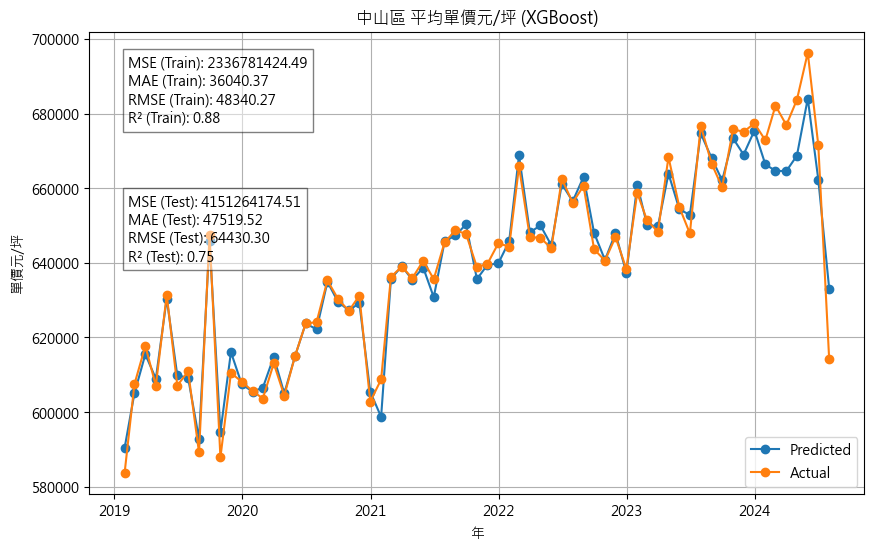

Top 20 features for 中山區:
             Feature  Importance
38                房齡    0.227265
39            貸款可負擔性    0.207234
40             總使用面積    0.097897
10                經度    0.085475
8               特殊交易    0.079888
9                 緯度    0.048706
5              主建物面積    0.046120
3        土地移轉總面積平方公尺    0.029055
23              租金指數    0.015606
61           建物型態_公寓    0.013203
22           消費者物價指數    0.012402
41            房屋格局指數    0.012031
4        車位移轉總面積平方公尺    0.009312
11      M1b貨幣供給額(億元)    0.007992
14                收盤    0.007494
70         車位類別_坡道平面    0.007180
12       M2貨幣供給額(億元)    0.006952
16            營造業指數值    0.006949
15            失業率(%)    0.006326
20  景氣領先&同時指標綜合指數(點)    0.004778
Processing data for district: 萬華區
Evaluating XGBoost
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_actual_prices = combined_actual.resample('M').mean()


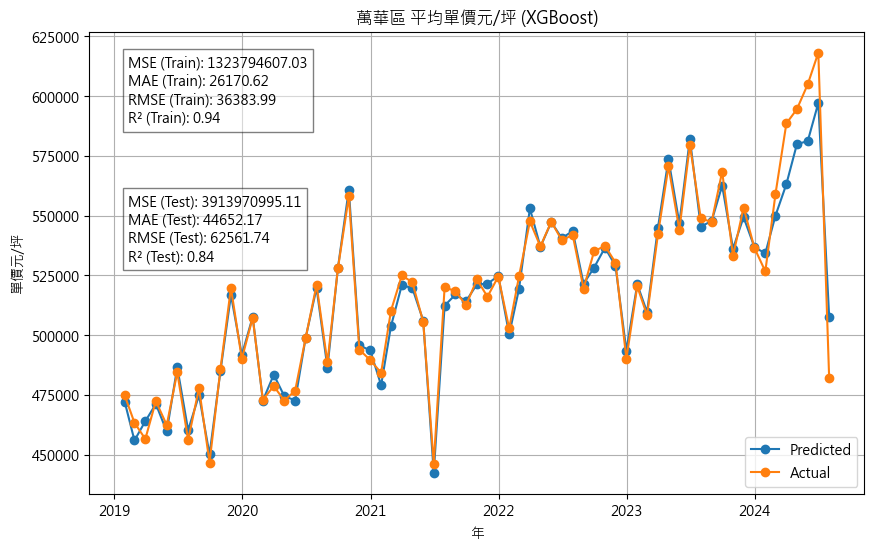

Top 20 features for 萬華區:
         Feature  Importance
38            房齡    0.269505
39        貸款可負擔性    0.191402
40         總使用面積    0.111509
8           特殊交易    0.098742
10            經度    0.077224
9             緯度    0.038303
3    土地移轉總面積平方公尺    0.027371
5          主建物面積    0.027039
69       建物型態_公寓    0.013393
41        房屋格局指數    0.012070
23          租金指數    0.011710
22       消費者物價指數    0.011121
11  M1b貨幣供給額(億元)    0.010404
16        營造業指數值    0.008950
74      建物型態_透天厝    0.008733
12   M2貨幣供給額(億元)    0.006732
4    車位移轉總面積平方公尺    0.005259
15        失業率(%)    0.005102
24       期中人口(人)    0.004996
14            收盤    0.004278
Processing data for district: 中正區
Evaluating XGBoost
--------------------------------------------------


C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_predicted_prices = combined_results.resample('M').mean()
C:\Users\student\AppData\Local\Temp\ipykernel_3664\992437076.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_actual_prices = combined_actual.resample('M').mean()


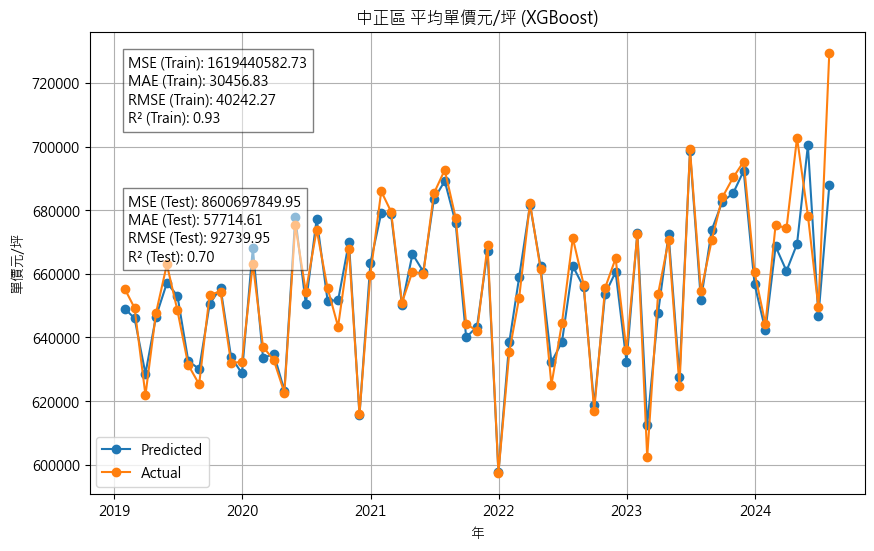

Top 20 features for 中正區:
             Feature  Importance
39            貸款可負擔性    0.247660
8               特殊交易    0.206629
40             總使用面積    0.100227
10                經度    0.095412
9                 緯度    0.065449
38                房齡    0.054375
5              主建物面積    0.039158
3        土地移轉總面積平方公尺    0.038604
41            房屋格局指數    0.010983
66           建物型態_公寓    0.010949
22           消費者物價指數    0.009505
14                收盤    0.008283
16            營造業指數值    0.007713
15            失業率(%)    0.006579
4        車位移轉總面積平方公尺    0.006061
11      M1b貨幣供給額(億元)    0.005345
20  景氣領先&同時指標綜合指數(點)    0.005150
2                  月    0.005012
21        景氣同時指標綜合指數    0.004725
17               投資率    0.004331
Processing data for district: 松山區


KeyboardInterrupt: 

In [19]:

plt.rc('font', family='Microsoft JhengHei')
# 定義模型
models = {'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)}

# 依照台北市各行政區處理數據
taipei_districts = df['鄉鎮市區'].unique()
for district in taipei_districts:
    print(f"Processing data for district: {district}")
    
    # 分區處理資料
    X_train_final, X_test_final, y_train, y_test, train_df, test_df = get_country(df, district)
    X_train_top, X_test_top, top_features = get_feature_importance(X_train_final, X_test_final, y_train, y_test)
    
    # 評估模型
    evaluate_model(models, X_train_top, y_train, X_test_top, y_test, train_df, test_df, district)
    
    print(f"Top 20 features for {district}:")
    print(top_features)
